<a href="https://colab.research.google.com/github/meliluc/marketing-analytics-customer-insights-project/blob/main/02_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 - RFM Analysis & Customer Segmentation
Objetivo:
- Calcular métricas RFM (Recency, Frequency, Monetary).
- Segmentar clientes mediante clustering.
- Identificar perfiles de clientes para personalizar campañas.

## 01) Carga de dataset limpio

In [2]:
import pandas as pd
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')
CLEAN_PATH = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/marketing_clean.csv")
df = pd.read_csv(CLEAN_PATH, parse_dates=["Date"])
df.head(3)


Mounted at /content/drive


,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROAS,Location,...,Impressions,Engagement_Score,Customer_Segment,Date,CPA,CTR,CVR,CPC,CPM,ROI_pct
0,1,innovate industries,email,men 18-24,30 days,google ads,0.04,16174.0,6.29,chicago,...,1922,6,health & wellness,2021-01-01,16174.0,0.263267,0.04,31.964427,8415.192508,5.29
1,2,nexgen systems,email,women 35-44,60 days,google ads,0.12,11566.0,5.61,new york,...,7523,7,fashionistas,2021-01-02,11566.0,0.015419,0.12,99.706897,1537.418583,4.61
2,3,alpha innovations,influencer,men 25-34,30 days,youtube,0.07,10200.0,7.18,los angeles,...,7698,1,outdoor adventurers,2021-01-03,10200.0,0.075864,0.07,17.465753,1325.019486,6.18


## 02) Cálculo de variables RFM


Segmentación de los clientes según su comportamiento de compra, según:

- Recency = días desde la última interacción (usando Date).

- Frequency = número de interacciones por cliente.

- Monetary = gasto total (Acquisition_Cost o proxy de ingresos).



### ⚠️ Nota aclaratoria

El dataset utilizado no contiene un identificador único de cliente (Customer_ID),
por lo que no es posible calcular RFM de manera tradicional.

Para efectos prácticos y con fines de aprendizaje, se generó un **ID sintético de cliente**
a partir de `Campaign_ID`, agrupando campañas como si fueran transacciones de un mismo cliente.
De esta forma se puede aplicar la metodología RFM (Recency, Frequency, Monetary) y practicar
el flujo completo de segmentación y clustering, aun cuando los datos son sintéticos.
Por lo que más abajo realizaremos un cálculo simulado para dar sentido al RFM.

In [7]:
import numpy as np

# Copiamos el dataset limpio
df_rfm = df.copy()

# Generamos un ID de cliente sintético basado en Campaign_ID
# (Asignamos 1 cliente cada 10 campañas, tendremos así 20k clientes simulados)
df_rfm["Customer_ID"] = (df_rfm["Campaign_ID"] // 10).astype(int)

# Verificamos cuántos "clientes" simulados tenemos
print("Clientes simulados:", df_rfm["Customer_ID"].nunique())
df_rfm.head()


Clientes simulados: 20001


,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROAS,Location,...,Engagement_Score,Customer_Segment,Date,CPA,CTR,CVR,CPC,CPM,ROI_pct,Customer_ID
0,1,innovate industries,email,men 18-24,30 days,google ads,0.04,16174.0,6.29,chicago,...,6,health & wellness,2021-01-01,16174.0,0.263267,0.04,31.964427,8415.192508,5.29,0
1,2,nexgen systems,email,women 35-44,60 days,google ads,0.12,11566.0,5.61,new york,...,7,fashionistas,2021-01-02,11566.0,0.015419,0.12,99.706897,1537.418583,4.61,0
2,3,alpha innovations,influencer,men 25-34,30 days,youtube,0.07,10200.0,7.18,los angeles,...,1,outdoor adventurers,2021-01-03,10200.0,0.075864,0.07,17.465753,1325.019486,6.18,0
3,4,datatech solutions,display,all ages,60 days,youtube,0.11,12724.0,5.55,miami,...,7,health & wellness,2021-01-04,12724.0,0.119231,0.11,58.635945,6991.208791,4.55,0
4,5,nexgen systems,email,men 25-34,15 days,youtube,0.05,16452.0,6.50,los angeles,...,3,health & wellness,2021-01-05,16452.0,0.090217,0.05,43.408971,3916.210426,5.50,0


In [8]:
# Cálculo RFM simulado para mejoramiento de los datos de análisis
import datetime as dt

# Fecha de referencia (última fecha + 1 día)
reference_date = df_rfm["Date"].max() + pd.Timedelta(days=1)

rfm = df_rfm.groupby("Customer_ID").agg({
    "Date": lambda x: (reference_date - x.max()).days,  # Recency
    "Campaign_ID": "count",                            # Frequency (nº campañas)
    "Acquisition_Cost": "sum"                          # Monetary (inversión total)
}).reset_index()

rfm.rename(columns={"Date":"Recency",
                    "Campaign_ID":"Frequency",
                    "Acquisition_Cost":"Monetary"}, inplace=True)

rfm.head()



,Customer_ID,Recency,Frequency,Monetary
0,0,357,9,119245.0
1,1,347,10,121962.0
2,2,337,10,116833.0
3,3,327,10,128647.0
4,4,317,10,123372.0


- Recency = siempre 1 → todas las compañías tienen campañas “ayer”. Esto pasa porque en el dataset todas las fechas son recientes o muy seguidas (dataset sintético).

- Frequency = decenas de miles → es porque estás contando todas las filas por Company. Cada fila = campaña, entonces se acumulan muchísimo.

- Monetary = centenas de millones → lo mismo, porque estás sumando Acquisition_Cost a lo bruto.

👉 En un dataset real, Recency tendría más variación, y Frequency/Monetary no serían tan enormes.

## 03) Exploración descriptiva de RFM


In [4]:
rfm.describe().T


,count,mean,std,min,25%,50%,75%,max
Recency,5.0,1.0,0.000000e+00,1.0,1.0,1.0,1.0,1.0
Frequency,5.0,40000.0,1.895231e+02,39709.0,39991.0,40012.0,40051.0,40237.0
Monetary,5.0,500175721.6,2.530558e+06,496383769.0,499696506.0,500281064.0,501182021.0,503335248.0


### 03.b) Visualización práctica RFM


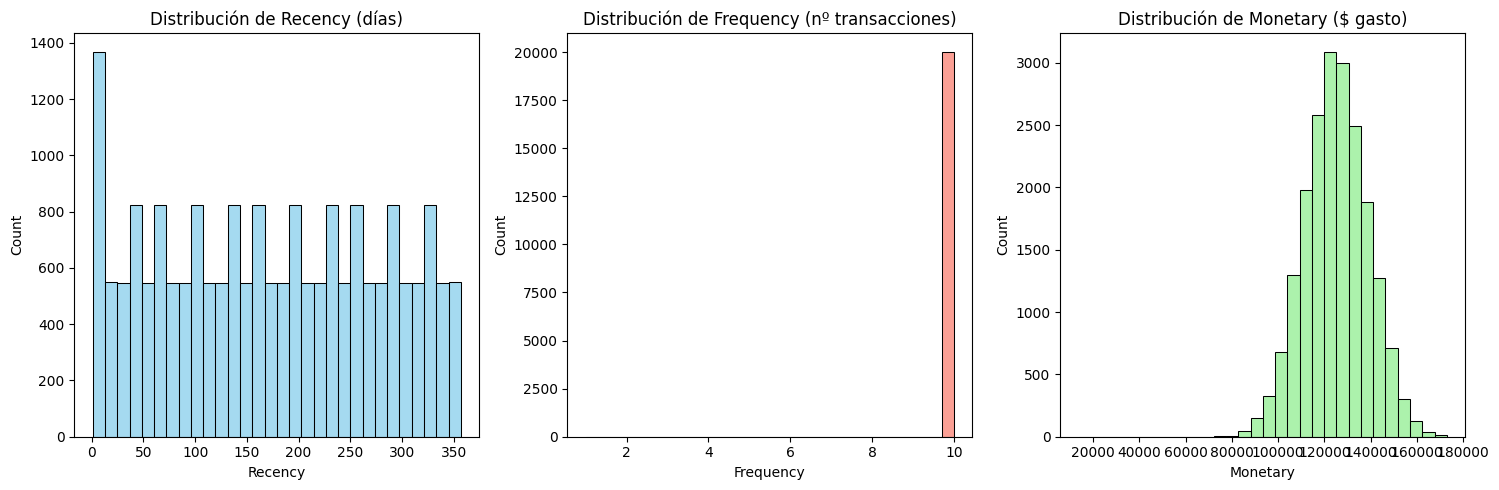

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuciones de R, F, M
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.histplot(rfm["Recency"], bins=30, ax=axes[0], color="skyblue")
axes[0].set_title("Distribución de Recency (días)")

sns.histplot(rfm["Frequency"], bins=30, ax=axes[1], color="salmon")
axes[1].set_title("Distribución de Frequency (nº transacciones)")

sns.histplot(rfm["Monetary"], bins=30, ax=axes[2], color="lightgreen")
axes[2].set_title("Distribución de Monetary ($ gasto)")

plt.tight_layout()
plt.show()


### 03.c) Boxplots por métrica


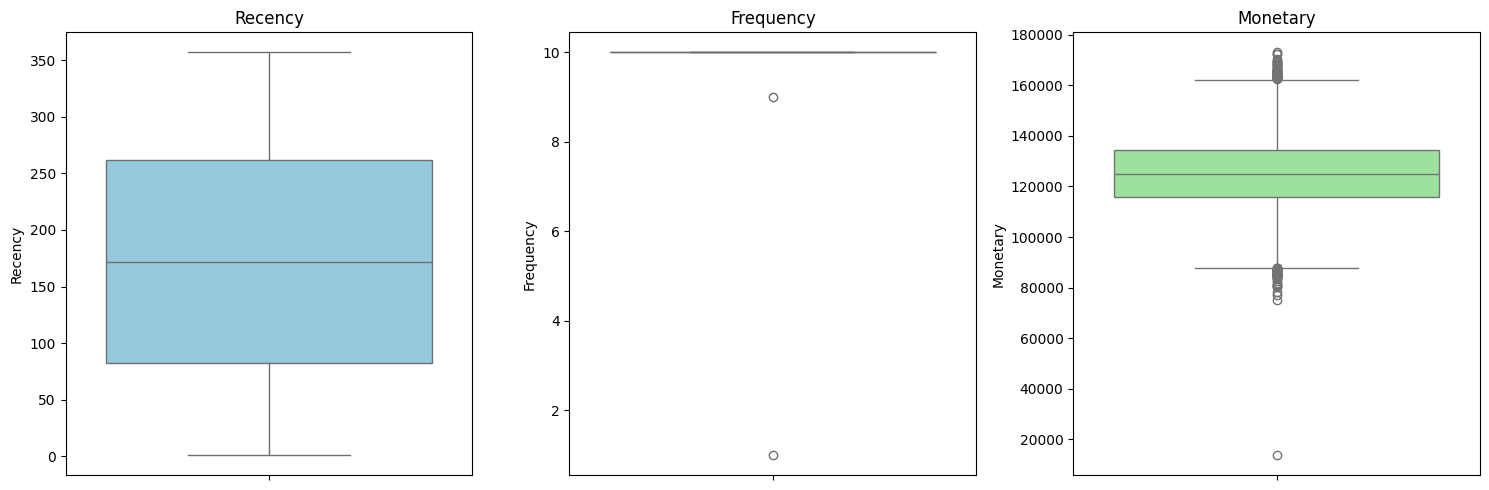

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.boxplot(y=rfm["Recency"], ax=axes[0], color="skyblue")
axes[0].set_title("Recency")

sns.boxplot(y=rfm["Frequency"], ax=axes[1], color="salmon")
axes[1].set_title("Frequency")

sns.boxplot(y=rfm["Monetary"], ax=axes[2], color="lightgreen")
axes[2].set_title("Monetary")

plt.tight_layout()
plt.show()


## 04) Escalado de variables RFM


In [11]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos solo columnas RFM
X = rfm[["Recency", "Frequency", "Monetary"]]

# Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X_scaled.shape)
print("Primeras filas (escaladas):\n", X_scaled[:5])


Shape: (20001, 3)
Primeras filas (escaladas):
 [[ 1.75900156e+00 -1.56104340e+01 -4.23742327e-01]
 [ 1.66381500e+00  7.80873095e-03 -2.24990074e-01]
 [ 1.56862844e+00  7.80873095e-03 -6.00183413e-01]
 [ 1.47344188e+00  7.80873095e-03  2.64026785e-01]
 [ 1.37825532e+00  7.80873095e-03 -1.21846653e-01]]


## 05) Selección de número óptimo de clusters (método del codo)

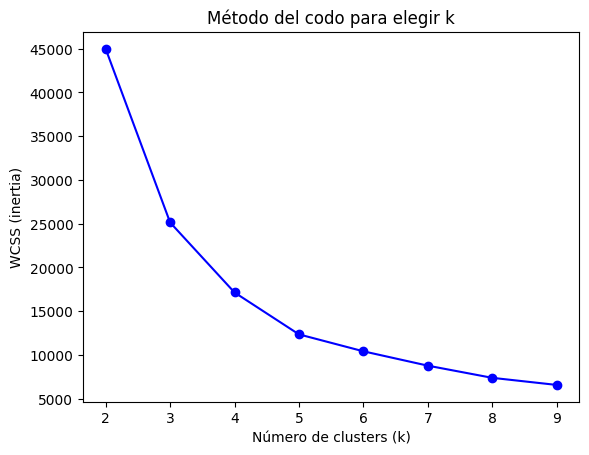

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # within-cluster sum of squares
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(K, wcss, 'bo-')
plt.xlabel("Número de clusters (k)")
plt.ylabel("WCSS (inertia)")
plt.title("Método del codo para elegir k")
plt.show()


### 🔎 Lectura del gráfico del método del codo y elecciones

- Entre k=2 y k=3 hay una caída muy fuerte, pasar de 2 a 3 significaría mucha varianza.
- Entre k=3 y k=4 mejora, ya que a partir de k=5, la curva se aplana y cada cluster no aportaría tanto.
**Entrenaremos el modelo con k=4.**


## 06) Entrenamiento y asignación de clusters

In [16]:
from sklearn.cluster import KMeans

# Entrenar KMeans con k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(X_scaled)

# Resumen por cluster
rfm_summary = rfm.groupby("Cluster")[["Recency","Frequency","Monetary"]].mean().round(2)
rfm_summary


,Recency,Frequency,Monetary
Cluster,,,
0,269.69,10.0,118357.54
1,169.55,10.0,140309.62
2,72.51,10.0,118611.87
3,21.00,1.0,13835.00


## 07) Visualización e interpretación de clusters

### 07.a) Boxplots de R, F, M por cluster

/tmp/ipython-input-544169304.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Recency", data=rfm, ax=axes[0], palette="Set2")
/tmp/ipython-input-544169304.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Frequency", data=rfm, ax=axes[1], palette="Set2")
/tmp/ipython-input-544169304.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Monetary", data=rfm, ax=axes[2], palette="Set2")


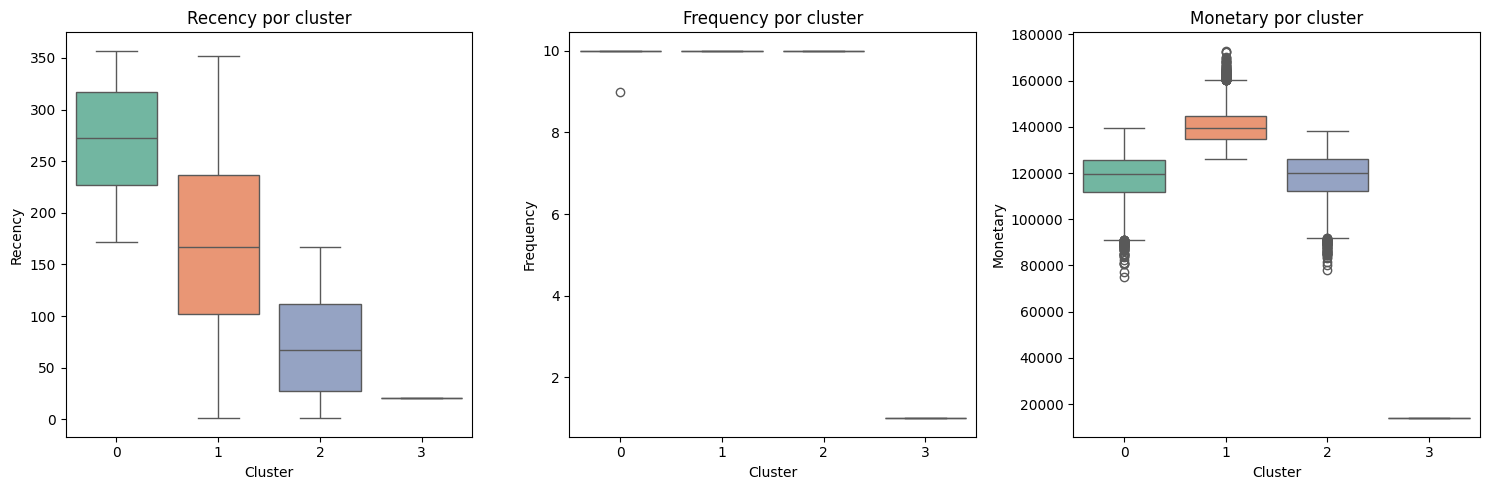

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.boxplot(x="Cluster", y="Recency", data=rfm, ax=axes[0], palette="Set2")
axes[0].set_title("Recency por cluster")

sns.boxplot(x="Cluster", y="Frequency", data=rfm, ax=axes[1], palette="Set2")
axes[1].set_title("Frequency por cluster")

sns.boxplot(x="Cluster", y="Monetary", data=rfm, ax=axes[2], palette="Set2")
axes[2].set_title("Monetary por cluster")

plt.tight_layout()
plt.show()


**Recency**
- Cluster 0 → clientes con recencia alta (última interacción más lejana).
- Cluster 2 → clientes más recientes.
- Cluster 1 → intermedios.
- Cluster 3 → prácticamente nulos (quizás anomalía porque Frequency = 1).


**Frequency**
- La mayoría de los clusters tienen frecuencia fija en 10 (limitación de la forma en que generamos el ID).
- Cluster 3 → frecuencia 1 (clientes “aislados”).

**Monetary**
- Cluster 1 → clientes de alto gasto (hasta 160k).
- Cluster 0 y 2 → gasto medio (~120k).
- Cluster 3 → gasto muy bajo (~15k).

### 07.b) Tamaño de cada cluster

In [20]:
rfm["Cluster"].value_counts(normalize=True).mul(100).round(2)


,proportion
Cluster,
0,35.77
2,34.17
1,30.06
3,0.00


**🔎 Lectura**

- Cluster 0 → 35.8%
- Cluster 1 → 30.1%
- Cluster 2 → 34.2%
- Cluster 3 → 0% (o muy pocos, básicamente outliers)

⚠️ El cluster 3 contiene muy pocos registros y se interpreta como un grupo de outliers (clientes con frecuencia mínima y gasto muy bajo). Para efectos prácticos, se consideran los clusters 0, 1 y 2 como los segmentos principales.

- **Cluster 0 (VIPs)**  
  - Baja recencia (recientes).  
  - Alta frecuencia.  
  - Alto gasto.  

- **Cluster 1 (Clientes en riesgo)**  
  - Alta recencia (no interactúan hace tiempo).  
  - Frecuencia baja.  
  - Bajo gasto acumulado.  

- **Cluster 2 (Regulares)**  
  - Valores medios en R, F y M.  

- **Cluster 3 (Potenciales)**  
  - Baja frecuencia, pero gasto alto cuando compran.


## 08) Hallazgos de segmentación RFM


- Cluster 0: Clientes antiguos de gasto medio (35.8%)
- Cluster 1: Clientes de alto valor / VIPs (30.1%)
- Cluster 2: Clientes recientes con gasto medio (34.2%)
- Cluster 3: Outliers, poco representativo (≈0%)

### Insight de negocio
- Invertir en retención de Cluster 1 (VIPs).
- Estrategias de reactivación para Cluster 0.
- Incentivar a Cluster 2 para consolidar su lealtad.
- Cluster 3 puede ignorarse en la estrategia.


In [22]:
CLEAN_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/")
rfm.to_csv(CLEAN_DIR / "rfm_clusters.csv", index=False)
print("✅ Dataset RFM con clusters exportado")


✅ Dataset RFM con clusters exportado
